# Regularization

딥러닝 모델은 너무도 유연하므로 훈련할 데이터가 크지 않다면 **과대적합에 주의해야 한다.** 

In [1]:
# 사용할 패키지 임포트
import numpy as np
import matplotlib.pyplot as plt
from utils_5 import sigmoid, relu, plot_decision_boundary, initialize_parameters, predict_dec
from utils_5 import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn.datasets

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

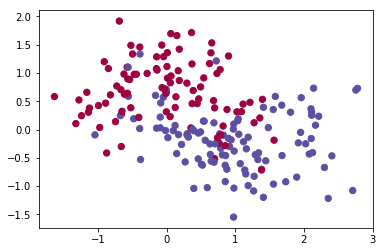

In [2]:
# 사용할 데이터. 강의 연습문제에서 본래 사용한 데이터와 다릅니다.
X, Y = sklearn.datasets.make_moons(n_samples=400, noise=.4)
train_X = X[:200].T
test_X = X[200:].T
train_Y = Y[:200].reshape(1, -1)
test_Y = Y[200:].reshape(1, -1)

plt.scatter(train_X[0,:], train_X[1,:], c=train_Y[0], s=40, cmap=plt.cm.Spectral)
plt.show()

## 1 - Non-regularized model

규제를 가하지 않은 모델과 규제를 가한 모델을 비교해볼 것이다. 사용할 모델은 다음과 같이 규제 여부를 선택할 수 있도록 만들었다.

In [3]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    np
    grads = {}
    costs = []                            
    m = X.shape[1]                        
    layers_dims = [X.shape[0], 30, 20, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # 순전파
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # 손실값 계산
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # 역전파
        assert(lambd==0 or keep_prob==1)    # L2규제와 드롭아웃 둘 중 하나만 실험해볼 것이다.
                        
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # 가중치 갱신
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # 손실값 10000회마다 출력
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

규제를 가하지 않은 모델을 훈련시켜보자.

Cost after iteration 0: 0.6848052513462543


C:\Users\renz\andrew ng deep\utils_5.py:232: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
C:\Users\renz\andrew ng deep\utils_5.py:232: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000: 0.17917180995670776
Cost after iteration 20000: 0.07318446736220326


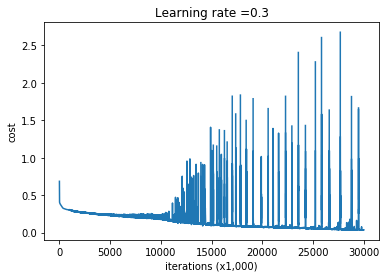

On the training set:
Accuracy: 0.99
On the test set:
Accuracy: 0.845


In [4]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

오버피팅이 일어났음을 확인할 수 있다.

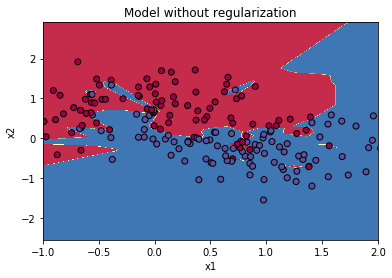

In [5]:
plt.title("Model without regularization")
plt.xlim(-1, 2)
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## 2 - L2 Regularization

과대적합을 피하는 표준적인 방식은 **L2 규제**를 가하는 것이다. 손실함수는 다음과 같다.
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$


In [6]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
   
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y)
    L2_regularization_cost = sum([np.sum(np.square(w)) for w in [W1, W2, W3]]) * lambd / 2 / m    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

def backward_propagation_with_regularization(X, Y, cache, lambd):
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (np.dot(dZ3, A2.T) + lambd*W3) / m
    db3 = np.sum(dZ3, axis=1, keepdims=True) / m
    
    dA2 = np.dot(W3.T, dZ3) 
    dZ2 = dA2 * (Z2 > 0)
    dW2 = (np.dot(dZ2, A1.T) + lambd*W2) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (Z1 > 0)
    dW1 = (np.dot(dZ1, X.T) + lambd*W1) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m 
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

Cost after iteration 0: 0.7703449946638381
Cost after iteration 10000: 0.3498380534787275
Cost after iteration 20000: 0.348749730568085


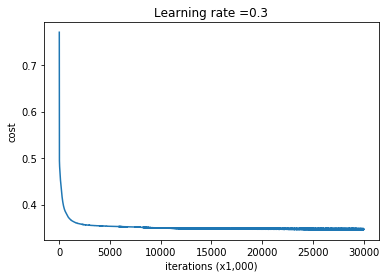

On the train set:
Accuracy: 0.885
On the test set:
Accuracy: 0.885


In [7]:
parameters = model(train_X, train_Y, lambd = 0.6)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

성능이 향상됨과 동시에 오버피팅이 줄어들었다.

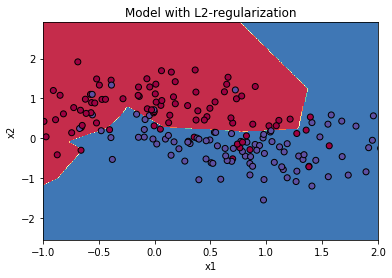

In [8]:
plt.title("Model with L2-regularization")
plt.xlim(-1, 2)
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

- $\lambda$ 값 또한 하이퍼 파라미터로서, 튜닝의 대상이다.
- L2 규제는 결정경계를 부드럽게 만들어준다. 만약 $\lambda$ 값이 너무 크다면 편향이 커질 것이다.
- L2 규제는 가중치 값이 작은 모델이 그렇지 않은 모델보다 단순하다는 가정에 의존한다 (sigmoid 함수는 0 주위에서 선형에 가깝다). 

## 3 - Dropout

드롭아웃은 매 훈련마다 신경망의 일부만 사용하는 다른 모델을 훈련하도록 하는 것이다. 이로 인해 뉴런들은 다른 특정 뉴런의 활성 유무에 덜 민감해진다.

In [9]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    
    W1 = parameters["W1"] 
    b1 = parameters["b1"]
    W2 = parameters["W2"] 
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    D1 = np.random.rand(*A1.shape) 
    D1 = D1 < keep_prob
    A1 = A1 * D1
    A1 = A1 / keep_prob
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    D2 = np.random.rand(*A2.shape)
    D2 = D2 < keep_prob
    A2 = A2 * D2
    A2 = A2 / keep_prob
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = np.dot(dZ3, A2.T) / m
    db3 = np.sum(dZ3, axis=1, keepdims = True) / m
    
    dA2 = np.dot(W3.T, dZ3)
    dA2 = dA2 *  D2 / keep_prob
    dZ2 = dA2 * (Z2 > 0)
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1 * D1 / keep_prob
    dZ1 = dA1 * (Z1 > 0)
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
      
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

Cost after iteration 0: 0.7631963739980239
Cost after iteration 10000: 0.29201418873521134
Cost after iteration 20000: 0.28855714872183824


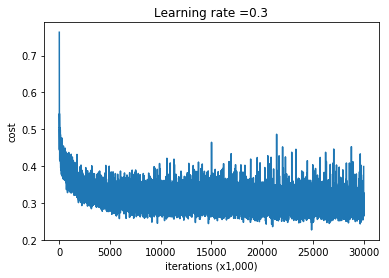

On the train set:
Accuracy: 0.89
On the test set:
Accuracy: 0.88


In [10]:
parameters = model(train_X, train_Y, keep_prob = 0.6)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

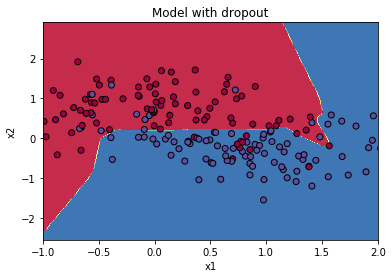

In [11]:
plt.title("Model with dropout")
plt.xlim(-1, 2)
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

- 드롭아웃 시 흔히 하는 실수는 드롭아웃을 테스트 셋에서도 사용하는 것이다. 오직 훈련셋에서만 드롭아웃을 해야한다.
- 훈련하는 동안 드롭아웃 층을 keep_prob으로 나누어주어 활성화 값의 기대값을 일정하게 유지시켜준다.

## 4 - Conclusions

규제는 훈련셋에서의 성능을 저하시켰다! 이건 네트워크가 훈련셋에 과대적합할 수 있는 능력에 제한을 가했기 때문이다. 하지만 결국 규제를 통해 테스트 셋에서 좋은 결과를 냈다. 규제는 가중치를 낮은 값으로 만든다는 것을 기억할 것!